In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
model = automap_base()
# reflect the tables
model.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
model.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
measurement = model.classes.measurement 
station = model.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(f"Most Recent Date: {recent}")

Most Recent Date: 2017-08-23


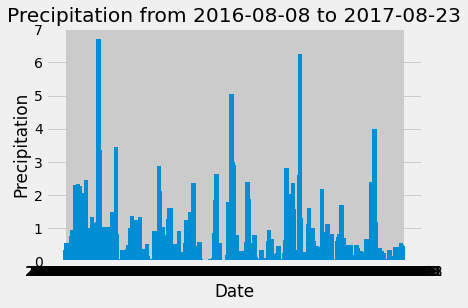

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_format = dt.datetime.strptime(recent, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
past_date = dt.date(recent_format.year - 1, recent_format.month, recent_format.month)
# Perform a query to retrieve the data and precipitation scores
selections = [measurement.date, measurement.prcp]
query = session.query(*selections).filter(measurement.date >= past_date).all()
# Save the query results as a Pandas DataFrame
precip_frame = pd.DataFrame(query, columns=['Date', 'Precipitation'])
precip_frame = precip_frame.dropna(how='any')
# Sort the dataframe by date and set the index to the date colum
precip_frame = precip_frame.sort_values(["Date"], ascending=True)
precip_frame = precip_frame.set_index("Date")
# Use Pandas Plotting with Matplotlib to plot the data

x_vals = precip_frame.index.tolist()
y_vals = precip_frame['Precipitation'].tolist()

plt.figure()
plt.bar(x_vals,y_vals,width=5,align='center')
plt.title(f"Precipitation from {past_date} to {recent}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_frame.describe()

# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.id).count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [42]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
selections = [measurement.station, func.count(measurement.id)]
active = session.query(*selections).group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

selections = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
station_data = session.query(*selections).group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
print(f"Min Temp: {station_data[0]}, Max Temp: {station_data[1]}, Average Temp: {station_data[2]}")

Min Temp: 54.0, Max Temp: 85.0, Average Temp: 71.66378066378067


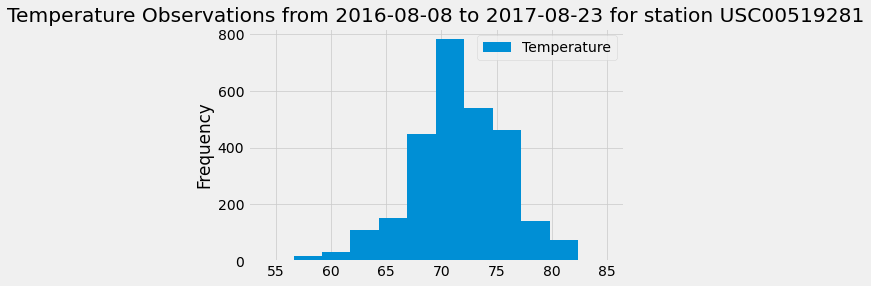

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.tobs).filter(measurement.station == active[0][0]).\
    filter(measurement.station >= past_date).all()
temps = list(np.ravel(query))

plt.hist(temps, bins=12, rwidth=1, label='Temperature')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature Observations from {past_date} to {recent} for station {active[0][0]}")
plt.legend()
plt.show()

# Close session

In [ ]:
# Close Session
session.close()